In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# %load ../frac_diff.py
import numpy as np
import pandas as pd
from scipy import interp
from scipy.stats import norm
from statsmodels.tsa.stattools import adfuller


def getWeights(d, size):
    '''
    Returns a list of coefficients to fractionally differentiate a time series. 

    @param d A non-negative real that represents the degree of the differentiation.
    @param size The number of items .
    @return A list with the fractionally differentiated coefficients.
    '''
    w = [1.]
    for k in range(1, size):
        w_ = -w[-1]/k*(d-k+1)
        w.append(w_)
    w = np.array(w[::-1]).reshape(-1, 1)
    return w


def getWeights_FFD(d, thres):
    '''
    Returns a list of coefficients to fractionally differentiate a time series. 

    @param d A non-negative real that represents the degree of the differentiation.
    @param thres The minimum absolute value that helps the stop adding items to the list of coefficients.
    @return A list with the fractionally differentiated coefficients.
    '''
    w = [1.]
    k = 1
    while True:
        w_ = -w[-1]/k*(d-k+1)
        if abs(w_) < thres:
            break
        w.append(w_)
        k += 1
    return np.array(w[::-1]).reshape(-1, 1)


def fracDiff(series, d, thres=0.01):
    '''
    Applies fractionally differentiation to time series. Uses threshold to determine the minimum
    value of coefficients the window will have.

    @param series A time series to apply the fractionally differentiation.
    @param d A non-negative real that represents the degree of the differentiation.
    @param thres A threshold to omit samples below that value. When it is 1, nothing is skipped.
    @return A DataFrame whose values are fractionally differentiated.
    '''
    # 1) Compute weights for the longest series
    w = getWeights(d, series.shape[0])
    # 2) Determine initial calcs to be skipped based on weight-loss threshold
    w_ = np.cumsum(abs(w))
    w_ /= w_[-1]
    skip = w_[w_ > thres].shape[0]
    # 3) Apply weights to values
    df = {}
    for name in series.columns:
        seriesF = series[[name]].fillna(method='ffill').dropna()
        df_ = pd.Series()
        for iloc in range(skip, seriesF.shape[0]):
            loc = seriesF.index[iloc]
            # must resample if duplicate index
            test_val = series.loc[loc, name]
            if isinstance(test_val, (pd.Series, pd.DataFrame)):
                test_val = test_val.resample('1m').mean()
            if not np.isfinite(test_val).any():
                continue  # exclude NAs
            try:
                df_.loc[loc] = np.dot(w[-(iloc+1):, :].T,
                                      seriesF.loc[:loc])[0, 0]
            except:
                continue
        df[name] = df_.copy(deep=True)
    df = pd.concat(df, axis=1)
    return df


def fracDiff_FFD(series, d, thres=1e-5):
    '''
    Applies fractionally differentiation to time series. Uses threshold to determine the minimum
    coefficient the window will have.

    @param series A DataFrame of time series to apply the fractionally differentiation.
    @param d A non-negative real that represents the degree of the differentiation.
    @param thres A threshold to omit samples below that value. When it is 1, nothing is skipped.
    @return A DataFrame whose values are fractionally differentiated.
    '''
    w = getWeights_FFD(d, thres)  # Constant width window (new solution)
    width = len(w)-1
    df = {}
    for name in series.columns:
        seriesF = series[[name]].fillna(method='ffill').dropna()
        df_ = pd.Series()
        for iloc1 in range(width, seriesF.shape[0]):
            loc0 = seriesF.index[iloc1-width]
            loc1 = seriesF.index[iloc1]
            # must resample if duplicate index
            test_val = series.loc[loc1, name]
            if isinstance(test_val, (pd.Series, pd.DataFrame)):
                test_val = test_val.resample('1m').mean()
            if not np.isfinite(test_val).any():
                continue  # exclude NAs
            try:
                df_.loc[loc1] = np.dot(w.T, seriesF.loc[loc0:loc1])[0, 0]
            except:
                continue
        df[name] = df_.copy(deep=True)
    df = pd.concat(df, axis=1)
    return df


def compute_multiple_ffd(close, threshold, dd):
    '''
    Iterates over @p close and fractionally differentiates the time series with
    @p dd degree. Uses coefficients whose absolute value is higher than @p threshold.

    @param close A DataFrame of time series to apply the fractionally differentiation.
    @param dd A non-negative real series that represents the degree of the differentiation.
    @param threshold A threshold to omit samples below that value. When it is 1, nothing is skipped.
    @return A DataFrame whose columns represent the output of the Augmented Dickey-Fuller statistic.
    '''
    out = pd.DataFrame(
        columns=['adfStat', 'pVal', 'lags', 'nObs', '95% conf', 'corr'])
    df0 = close
    for d in dd:
        # downcast to daily obs. Dropped NAs
        df1 = np.log(df0).resample('1D').last().dropna()
        df2 = fracDiff_FFD(df1, d, thres=threshold).dropna()
        corr = np.corrcoef(df1.loc[df2.index, 'Close'], df2['Close'])[0, 1]
        df2 = adfuller(df2['Close'], maxlag=1, regression='c', autolag=None)
        out.loc[d] = list(df2[:4]) + [df2[4]['5%']] + \
            [corr]  # with critical value
    return out


def get_d_optim(out, conf=0.05):
    '''
    Returns the maximum differentiation degree that makes the p-value
    of @p out to be less than @p conf.

    @param out The output of compute_multiple_ffd().
    @param conf The confidence value.
    @return The optimal differentiation degree.
    '''
    return out[out.pVal < conf].pVal.idxmax()


In [29]:
k = np.linspace(0, 9, 10)
d = np.linspace(0, 2, 11)
w = [getWeights(d_, len(k)) for d_ in d] 

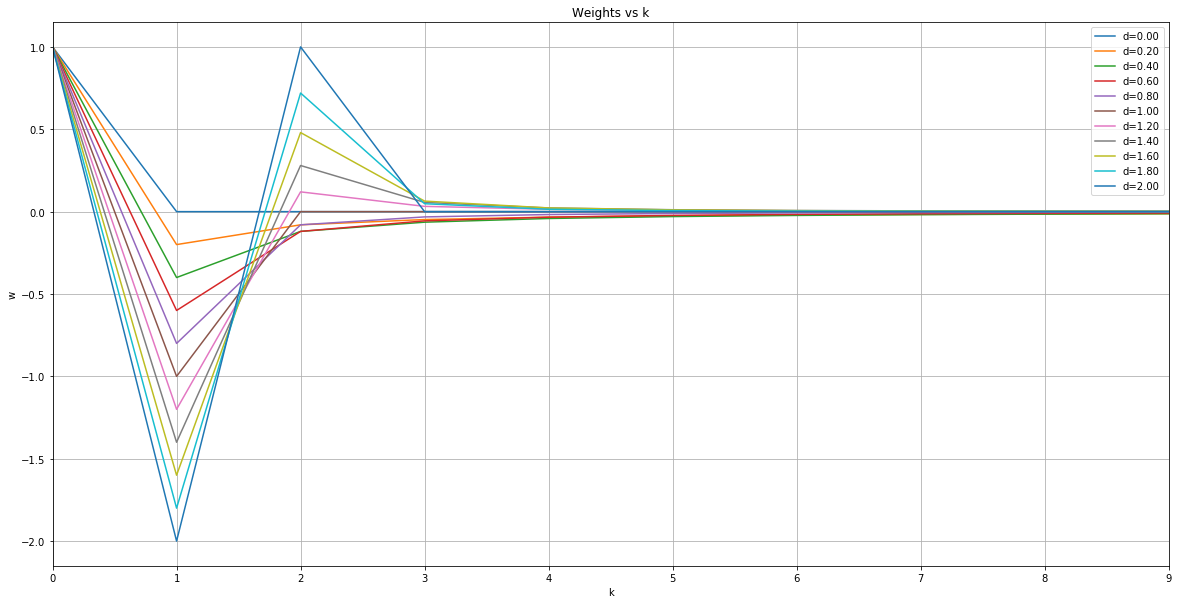

In [32]:
fig = plt.figure(figsize=(20,10))
for i in range(0, len(d)):
    plt.plot(k, w[i][::-1], label='d={:.2f}'.format(d[i]))
plt.grid()
plt.title('Weights vs k')
plt.xlabel('k')
plt.ylabel('w')
plt.xlim(min(k), max(k))
plt.xticks(k)
plt.legend()